In [1]:
import json
import yfinance as yf
import numpy as np
import pandas as pd
import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

In [2]:
start = pd.to_datetime('2007-07-07')

In [3]:
stock = ['AMZN']

In [4]:
data = yf.download(stock, start=start, end=datetime.date.today())

[*********************100%***********************]  1 of 1 completed


In [5]:
min_max = preprocessing.MinMaxScaler()

In [6]:
data_scaled = pd.DataFrame(min_max.fit_transform(data), columns=data.columns)

In [7]:
data_scaled_close = data_scaled['Close']

In [8]:
data_scaled_close

0       0.010021
1       0.009536
2       0.009658
3       0.010215
4       0.010840
          ...   
3881    0.482951
3882    0.468017
3883    0.469154
3884    0.479380
3885    0.472562
Name: Close, Length: 3886, dtype: float64

In [9]:
np.array(data_scaled_close).reshape(-1, 1).shape

(3886, 1)

In [10]:
train_num = int(data_scaled.shape[0] * 0.7)

In [11]:
test = pd.Timestamp("2018-07-31 00:00:00", tz="America/New_York")

In [12]:
data['Close'][data.index > test]

Date
2018-08-01 00:00:00-04:00    89.858498
2018-08-02 00:00:00-04:00    91.716499
2018-08-03 00:00:00-04:00    91.164497
2018-08-06 00:00:00-04:00    92.387497
2018-08-07 00:00:00-04:00    93.124001
                               ...    
2022-12-05 00:00:00-05:00    91.010002
2022-12-06 00:00:00-05:00    88.250000
2022-12-07 00:00:00-05:00    88.459999
2022-12-08 00:00:00-05:00    90.349998
2022-12-09 00:00:00-05:00    89.089996
Name: Close, Length: 1099, dtype: float64

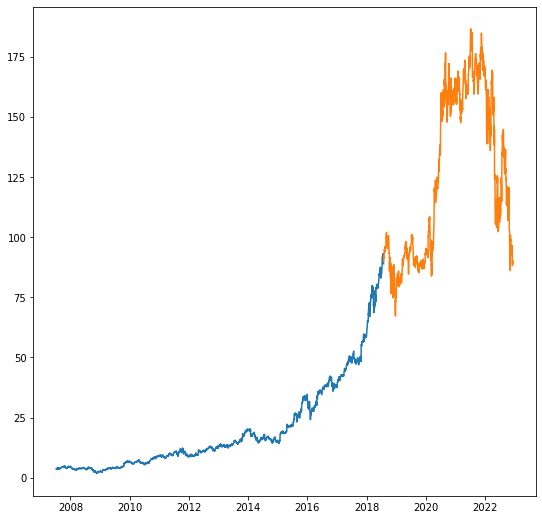

In [13]:
plt.figure(figsize=(9, 9))

plt.plot(data['Close'][data.index < test])
plt.plot(data['Close'][data.index > test])
plt.show()

In [14]:
data_train = np.array(data_scaled['Close'][data.index < test]).reshape(-1, 1)
data_test = np.array(data_scaled['Close'][data.index > test]).reshape(-1, 1)
#data_train = data_scaled['Close'][data.index < test]
#data_test = data_scaled['Close'][data.index > test]

In [15]:
data_train.shape[0]

2786

In [16]:
len(data_train)

2786

In [17]:
data_test.shape

(1099, 1)

In [18]:
def get_train(train_scaled, time_steps = 3):
    x_train = []
    y_train = []
    for i in range(time_steps, train_scaled.shape[0]):
        x_train.append(train_scaled[i - time_steps:i, 0])
        y_train.append(train_scaled[i, 0])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train

In [19]:
x_train, y_train = get_train(data_train, time_steps = 3)

In [20]:
print("x.shape = ", x_train.shape, ", y.shape = ", y_train.shape)

x.shape =  (2783, 3, 1) , y.shape =  (2783,)


In [21]:
my_dataset = tf.keras.utils.timeseries_dataset_from_array(data_train, targets=data_train[3:], sequence_length=3, batch_size=2)

In [22]:
seq_length = 3
train_ds = tf.keras.utils.timeseries_dataset_from_array(data_train, targets=data_train[seq_length:],
                                                        sequence_length=seq_length,
                                                        batch_size=32,
                                                        shuffle=False,
                                                        seed=42)


In [23]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [24]:
my_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1), dtype=tf.float64, name=None))>

In [25]:
def get_test(test_scaled, time_steps = 3):
    x_test = []
    y_test = []
    for i in range(time_steps, test_scaled.shape[0]):
        x_test.append(test_scaled[i - time_steps:i])
        y_test.append(test_scaled[i, 0])
        
    x_test, y_test = np.array(x_test), np.array(y_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

In [26]:
x_test, y_test = get_test(data_test, time_steps = 3)

In [27]:
print("xt.shape = ", x_test.shape, ", yt.shape = ", y_test.shape)

xt.shape =  (1096, 3, 1) , yt.shape =  (1096,)


In [28]:
def long_short_term_memory_model(alpha=0.2, time_steps = 10):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, 10, activation='relu', strides=1, padding='causal', input_shape=[time_steps, 1]))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(alpha))
    
    model.add(layers.LSTM(64))
    model.add(layers.Dense(1))

    return model

In [29]:
model = long_short_term_memory_model(alpha=0.2, time_steps = 3)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 3, 64)             704       
                                                                 
 dropout (Dropout)           (None, 3, 64)             0         
                                                                 
 lstm (LSTM)                 (None, 3, 128)            98816     
                                                                 
 dropout_1 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 3, 128)            131584    
                                                                 
 dropout_2 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                4

In [30]:
defined_metrics = tf.keras.metrics.MeanSquaredError() 
defined_loss = tf.keras.losses.MeanSquaredError()
opt_adam = tf.keras.optimizers.Adam(learning_rate=0.00025) 

model.compile(optimizer=opt_adam, loss=defined_loss, metrics=defined_metrics)

In [37]:
history = model.fit(x_train, y_train, epochs=60, batch_size=1024, validation_data=(x_test, y_test))

Epoch 1/60
3/3 [==============================] - 0s 124ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.2819 - val_mean_squared_error: 0.2819
Epoch 2/60
3/3 [==============================] - 0s 106ms/step - loss: 0.0096 - mean_squared_error: 0.0096 - val_loss: 0.2698 - val_mean_squared_error: 0.2698
Epoch 3/60
3/3 [==============================] - 0s 114ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - val_loss: 0.2645 - val_mean_squared_error: 0.2645
Epoch 4/60
3/3 [==============================] - 0s 111ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.2628 - val_mean_squared_error: 0.2628
Epoch 5/60
3/3 [==============================] - 0s 108ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.2607 - val_mean_squared_error: 0.2607
Epoch 6/60
3/3 [==============================] - 0s 113ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.2554 - val_mean_squared_error: 0.2554
Epoch 7/60
3/3 [========================

In [38]:
output = model.predict(x_test)

35/35 [==============================] - 0s 4ms/step


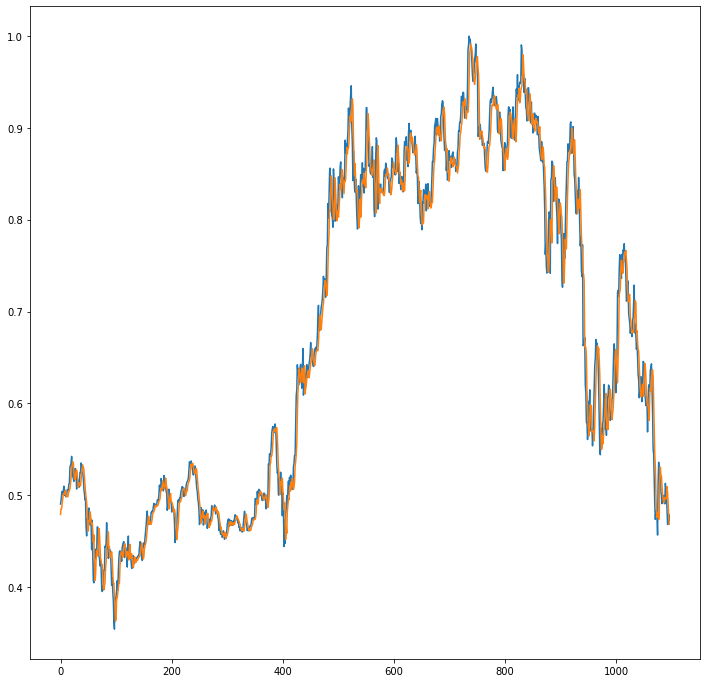

In [39]:
plt.figure(figsize=(12, 12))

plt.plot(y_test[:])
plt.plot(output[:])
plt.show()

In [40]:
result = y_test[:3]
for i in range(100):
    temp = model.predict(result[result.shape[0] - 3 : ].reshape([1, 3, 1]))
    result = np.append(result, temp)

1/1 [==============================] - 0s 21ms/step


In [41]:
result.shape

(103,)

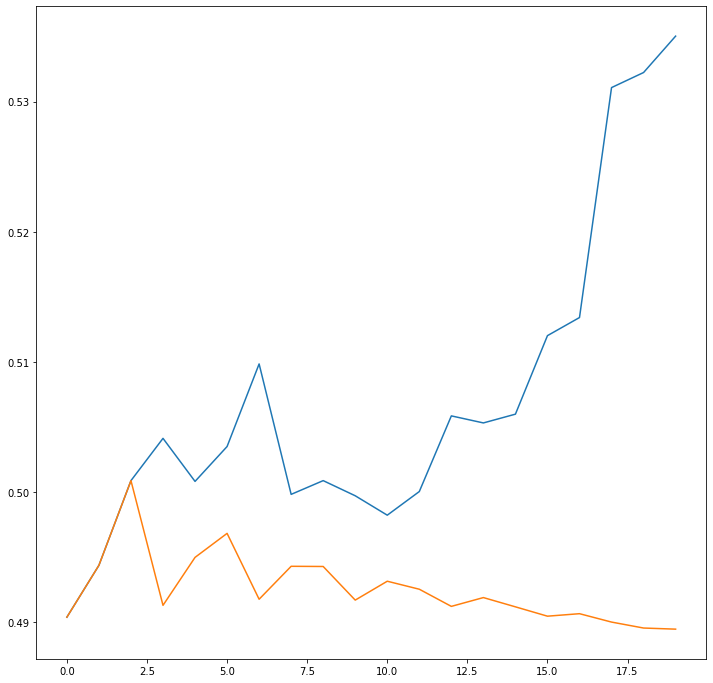

In [42]:
plt.figure(figsize=(12, 12))

plt.plot(y_test[:20])
plt.plot(result[:20])
plt.show()